# Evaluación de Rendimiento

a continuación se comparan los resultados del video sin alinear y el video alineado. Para esto se compara cada frame con respecto al primero aplicando la diferencia absoluta, PSNR y SSIM.

Se destaca como la mayor diferencia entre el video alineado y no alineado son los autos en las autopistas.

(obs: Mientras más oscura es la imagen menor es la diferencia entre frames)

In [32]:
# @title Importar dependencias {form-width: "25%"}

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
import csv
import os

In [33]:
# @title Declarar Funciones Auxiliares {form-width: "25%"}

def crop_frames(frame, crop_width, crop_height):
    if crop_width == 0 or crop_height == 0:
        return frame
    # Recorta una ventana de tamaño crop_width x crop_height centrada en el frame
    height, width = frame.shape[:2]
    x = int(height/2)
    y = int(width/2)

    cropped_frame = frame[y:y + crop_height, x:x + crop_width]
    return cropped_frame

def plot_line_graph(data_list, tags, title, save_folder="benchmark_plots", figsize=(13, 13), id=None):
    x = range(len(data_list[0]))  # Assuming all data arrays have the same length
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define a list of colors for lines (add more as needed)

    plt.figure(figsize=figsize)
    
    # Set white background and adjust text color
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    
    for i, data in enumerate(data_list):
        if i < len(colors):
            color = colors[i]
        else:
            color = 'gray'  # Use default color for lines beyond the available colors
        
        if i < len(tags):
            label = tags[i]
        else:
            label = f"Line {i+1}"

        plt.plot(x, data, color=color, label=label)

    plt.xlabel("Fotogramas")
    plt.ylabel("SSIM")
    plt.title(title)

    if id is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        plot_filename = os.path.join(save_folder, f'{title}.png')
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

    plt.legend()
    plt.grid(True)
    plt.show()

def insolate_img_color(frame, color_channel=3):
  # 0 para azul, 1 para verde, 2 para rojo
  # Convertir frames a escala de grises si no se especifica color_channel
  # 4 para RGB
  if color_channel == 3:
    insolated_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  elif color_channel == 4:
    insolated_frame = frame
  else:
    # Extraer el canal de color especificado
    insolated_frame = frame[:,:,color_channel]
  return insolated_frame

def calculate_psnr_ssim(frame1, frame2):
  # Calcular el PSNR y SSIM entre dos frames
  max_pixel_value = np.max(frame1)
  psnr = cv2.PSNR(frame1, frame2, max_pixel_value)

  ssim = compare_ssim(frame1, frame2)
  return psnr, ssim

def record_benchmark_data(video_path,
                          height,
                          width,
                          crop_width, 
                          crop_height, 
                          title, 
                          color_channel, 
                          nfeatures,
                          frames_ssim_mean,
                          frames_psnr_mean,
                          frames_diff_mean,
                          max_diff,
                          max_psnr,
                          min_ssim
                          ):
    
    csv_file = 'benchmark_data.csv'

    # crea el archivo si no existe
    if not os.path.exists(csv_file):
        with open(csv_file, mode='w', newline='') as file:
            writer = csv.writer(file, delimiter=';')
            writer.writerow(['ID', 'Video Path', 'Height', 'Width', 'N Features', 'Frames SSIM Mean', 'Frames PSNR Mean',
                             'Frames Diff Mean', 'Max Diff', 'Max PSNR', 'Min SSIM', 'Crop Width', 'Crop Height', 'Title',
                             'Color Channel'])

    # leé el último ID del archivo
    last_id = 0
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file, delimiter=';')
        for row in reader:
            last_id = max(last_id, int(row['ID']))

    # Incrementa el ID en 1
    new_id = last_id + 1

    data = [new_id, video_path, height, width, nfeatures, frames_ssim_mean, frames_psnr_mean, 
            frames_diff_mean, max_diff, max_psnr, min_ssim, crop_width, crop_height, title, 
            color_channel]

    # Agrega los datos al archivo
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(data)
    return new_id

Processed frame 0/901
Processed frame 100/901
Processed frame 200/901
Processed frame 300/901
Processed frame 400/901
Processed frame 500/901
Processed frame 600/901
Processed frame 700/901
Processed frame 800/901
Diferencia promedio: 26.834 con un máximo de: 34.177 (Con 0 son identicas)
PSNR promedio: 17.377 con un máximo de: 360.89
SSIM promedio: 0.197 con un mínimo de: 0.098 (Con 1 son idénticas)
Processed frame 0/901
Processed frame 100/901
Processed frame 200/901
Processed frame 300/901
Processed frame 400/901
Processed frame 500/901
Processed frame 600/901
Processed frame 700/901
Processed frame 800/901
Diferencia promedio: 12.645 con un máximo de: 19.394 (Con 0 son identicas)
PSNR promedio: 19.994 con un máximo de: 34.502
SSIM promedio: 0.771 con un mínimo de: 0.591 (Con 1 son idénticas)
Processed frame 0/901
Processed frame 100/901
Processed frame 200/901
Processed frame 300/901
Processed frame 400/901
Processed frame 500/901
Processed frame 600/901
Processed frame 700/901
Proc

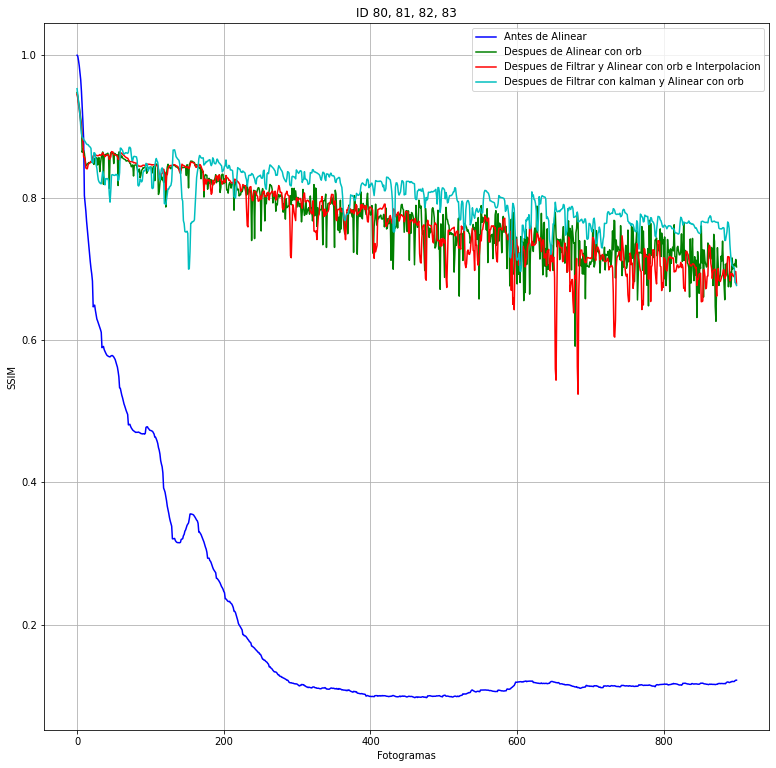

In [34]:
def benchmark_frames(video_path, crop_width, crop_height, title, nfeatures, color_channel=3):
  # Open the video file
  video_capture = cv2.VideoCapture(video_path)
  total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

  ret, reference_frame = video_capture.read()
  cropped_reference_frame = crop_frames(reference_frame, crop_width, crop_height)
  cropped_reference_frame = insolate_img_color(cropped_reference_frame, color_channel) # Insolate the color channel

  frame_count = 0
  frames_diff = []
  frames_psnr = []
  frames_ssim = []
  max_diff = 0
  max_psnr = 0
  min_ssim = 1
  while True:
    # Read a frame from the video
    ret, frame = video_capture.read()
    if not ret:
      break

    cropped_current_frame = insolate_img_color(crop_frames(frame, crop_width, crop_height), color_channel)

    # Compute the absolute difference between the cropped frames
    diff = cv2.absdiff(cropped_reference_frame, cropped_current_frame)
    avg_diff = np.mean(diff)
    frames_diff.append(avg_diff)  # Add the new mean difference to the log

    # Calculate the PSNR and SSIM
    psnr, ssim = calculate_psnr_ssim(cropped_reference_frame, cropped_current_frame)
    frames_psnr.append(psnr)
    frames_ssim.append(ssim)

    # Get the max PSNR, SSIM and ssim
    if max_diff < avg_diff:
      max_diff = avg_diff
    if max_psnr < psnr:
      max_psnr = psnr
    if min_ssim > ssim:
      min_ssim = ssim

    if (frame_count % 100 == 0):
      print(f"Processed frame {frame_count}/{total_frames}")
    frame_count += 1
  
  video_capture.release()

  frames_diff_mean = round(np.mean(frames_diff),3)
  frames_psnr_mean = round(np.mean(frames_psnr),3)
  frames_ssim_mean = round(np.mean(frames_ssim),3)

  # Display the data
  print(f"Diferencia promedio: {frames_diff_mean} con un máximo de: {round(max_diff,3)} (Con 0 son identicas)")
  print(f"PSNR promedio: {frames_psnr_mean} con un máximo de: {round(max_psnr,3)}")
  print(f"SSIM promedio: {frames_ssim_mean} con un mínimo de: {round(min_ssim,3)} (Con 1 son idénticas)")
  # Display and record data
  height = reference_frame.shape[0]
  width = reference_frame.shape[1]
  new_id = record_benchmark_data(video_path,
                          height,
                          width,
                          crop_width, 
                          crop_height, 
                          title, 
                          color_channel, 
                          nfeatures,
                          frames_ssim_mean,
                          frames_psnr_mean,
                          frames_diff_mean,
                          max_diff,
                          max_psnr,
                          min_ssim)
  return new_id, frames_ssim, title
    
video_name = "video1_30s.mp4"
NFEATURES = 1000
METHOD = "sift"
window_size = 500

# Compare the cropped frames
# benchmark_frames("video_sim_30s_movement_alejandra.mp4", 400, 400, "Despues de Alinear Metodo Anterior", "X")
id1, frames_ssim1, title1 = benchmark_frames(video_name, window_size, window_size, "Antes de Alinear", 0)
id2, frames_ssim2, title2 = benchmark_frames(video_name.replace(".mp4", f"_{METHOD}_estabilizado.mp4" ), window_size, window_size, f"Despues de Alinear con {METHOD}", NFEATURES)
id3, frames_ssim3, title3 = benchmark_frames(video_name.replace(".mp4", f"_{METHOD}_estabilizado_filtrado.mp4"), window_size, window_size, f"Despues de Filtrar y Alinear con {METHOD} e Interpolacion", NFEATURES)
id4, frames_ssim4, title4 = benchmark_frames(video_name.replace(".mp4", f"_{METHOD}_estabilizado_filtrado_kalman.mp4"), window_size, window_size, f"Despues de Filtrar con kalman y Alinear con {METHOD}", NFEATURES)

a_ssim = [frames_ssim1, frames_ssim2, frames_ssim3, frames_ssim4]
tags = [title1, title2, title3, title4]
ids =  f"ID {id1}, {id2}, {id3}, {id4}"

plot_line_graph(a_ssim, tags, ids, id=ids)